In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from functools import reduce

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from glob import glob
import time
pd.set_option('display.float_format', '{:.6f}'.format)
np.set_printoptions(suppress=True)
pio.templates.default = 'plotly_white'

In [2]:
def process_sector_data(sector_info): 
    # Get the symbol available in daily data
    files = glob('../data/historical_data/*.csv')
    available_daily_symbol = [file[-7:-4] for file in files]
    
    # Drop symbol whose sectors are NaN
    sector_info.dropna(subset=['sector'], inplace=True)

    
    # Sector mask for current daily symbols
    mask_daily_universe = sector_info['ticker'].isin(available_daily_symbol)
    daily_universe = sector_info[mask_daily_universe]
    
    # Mapping Sector
    sector_mapping = {
        'Financials': ['Bảo hiểm', 'Dịch vụ tài chính', 'Tổ chức tín dụng'],
        'Information Technology': ['Chất bán dẫn và thiết bị bán dẫn', 'Công nghệ phần cứng và thiết bị', 'Phần mềm và dịch vụ'],
        'Health Care': ['Dược phẩm, Công nghệ sinh học và Khoa học thường thức', 'Dịch vụ và thiết bị chăm sóc sức khỏe'],
        'Consumer Discretionary': ['Dịch vụ tiêu dùng', 'Hàng tiêu dùng và trang trí', 'Phân phối và bán lẻ hàng lâu bền', 'Xe và linh kiện', 'Đồ gia dụng và cá nhân'],
        'Utilities': ['Dịch vụ tiện ích'],
        'Communication Services': ['Dịch vụ viễn thông', 'Truyền thông và giải trí'],
        'Materials': ['Nguyên vật liệu'],
        'Energy': ['Năng lượng'],
        'Real Estate': ['Phát triển và quản lý bất động sản'],
        'Consumer Staples': ['Thực phẩm, đồ uống và thuốc lá'],
        'Industrials': ['Dịch vụ chuyên biệt và thương mại', 'Tư liệu sản xuất', 'Vận tải']
    }
    
    # Reverse sector_mapping 
    industry_to_sector = {industry: sector for sector, industries in sector_mapping.items() for industry in industries}
    mapped_sector = daily_universe['sector'].map(industry_to_sector)

    # Add new Sector column based on sector_mapping
    daily_universe.loc[:, ['mapped sector']] = mapped_sector.values

    # Rename 'Sector' and 'Mapped Sector' columns
    daily_universe = daily_universe.rename(columns={
                         'sector': 'Industry Groups',
                         'mapped sector': 'sector'
                         })
    # Reset index
    daily_universe.reset_index(drop=True, inplace=True)
    
    return daily_universe

def find_symbol_enough_field(files):      
    not_enough_field = []
    validate_col = set(['P/B', 'Market Capital', 'Outstanding Share'])

    for file in files:
        df = pd.read_csv(file)

        if not validate_col.issubset(set(df.columns)):
            not_enough_field.append(file)

    valid_symbol = set(files).difference(not_enough_field)
    
    return valid_symbol

def process_fundamental_data(df: pd.DataFrame):
    fields = ['ticker', 'yearReport', 'lengthReport', 'P/B','Outstanding Share']
    
    df = df.sort_values(by=['yearReport', 'lengthReport'])
    df = df.replace(to_replace=0, value=np.nan).bfill()
    
    return df[fields]


def get_risk_free_rate(file):     
    df = pd.read_csv(file)
    df.rename(columns={
                      'Date': 'time',
                      'Close': 'rf',
                      'Open': 'open',
                      'High': 'high',
                      'Low': 'low'
                      },
              inplace=True
    )
    df.drop(columns=['open', 'high', 'low','Change %'], inplace=True)
    
#     df['rf'] = np.exp(df['rf'] / 250) - 1
        
    df['time'] = pd.to_datetime(df['time'])
    
    return df

def get_enough_data_folder(fundamental_path, historical_path, symbols): 
    fundamental_folder = [fundamental_path + f'/{symbol}.csv' for symbol in symbols]
    historical_folder = [historical_path + f'/{symbol}.csv' for symbol in symbols]
    
    return fundamental_folder, historical_folder

def get_enough_data_folder(fundamental_path, historical_path, symbols): 
    fundamental_folder = [fundamental_path + f'/{symbol}.csv' for symbol in symbols]
    historical_folder = [historical_path + f'/{symbol}.csv' for symbol in symbols]
    
    return fundamental_folder, historical_folder

def drop_duplicate_date(df): 
    df = df.drop_duplicates(subset='time', keep='first')
    
    return df

def calculate_return(df: pd.DataFrame):
    df['r'] =  np.log(df['close']/df['close'].shift(1))
    
    return df.iloc[1:]

def get_universe(): 
    files = glob('../data/fundamental_data/*.csv')
    sector_info = pd.read_csv('../data/gics/gics.csv')

    # Filter out symbols that have enough data fields
    symbol_enough_field = find_symbol_enough_field(files)
    enough_field_symbols = [symbol[-7:-4] for symbol in symbol_enough_field]
    
    sector_info = process_sector_data(sector_info)
    mask_non_financial_sector = sector_info['sector'] != 'Financials'
    
    non_financial_sector = set(sector_info[mask_non_financial_sector]['ticker'])
    universe = non_financial_sector.intersection(enough_field_symbols)

    return universe

In [3]:
universe = get_universe()
print("The number of stock in the universe: ", len(universe))

The number of stock in the universe:  1249


In [4]:
fundamental_path = '../data/fundamental_data'
historical_path = '../data/historical_data'

fundamental_folder, historical_folder = get_enough_data_folder(fundamental_path, historical_path, universe)

In [5]:
dtype_dict = {
    'ticker': 'object',
    'yearReport': 'int64',
    'lengthReport': 'int64',
    'P/B': 'float64',
    'Outstanding Share': 'float64',
    'Market Capital': 'float64',
    'EBIT (Bn. VND)': 'float64'
}

fundamental_data = dd.read_csv(fundamental_folder, dtype=dtype_dict)
historical_data = dd.read_csv(historical_folder)

In [6]:
meta_fundamental = pd.DataFrame({
    'ticker': pd.Series(dtype='string'),
    'yearReport': pd.Series(dtype='int16'),
    'lengthReport': pd.Series(dtype='int16'),
    'P/B': pd.Series(dtype='float64'),
    'Outstanding Share': pd.Series(dtype='int64')
})

fundamental_data = fundamental_data.map_partitions(process_fundamental_data, meta=meta_fundamental)
fundamental_data = fundamental_data.compute() 
fundamental_data = fundamental_data.reset_index(drop=True)

In [7]:
# historical_data = historical_data.map_partitions(calculate_return)

historical_data = historical_data.map_partitions(drop_duplicate_date)
historical_data['time'] = dd.to_datetime(historical_data['time'])
historical_data['yearReport'] = historical_data['time'].dt.year
historical_data['lengthReport'] = historical_data['time'].dt.quarter
historical_data = historical_data.compute()

historical_data = historical_data.reset_index(drop=True)

In [8]:
def process_benchmark_data(): 
    df = pd.read_csv('../data/benchmark/dc_performance.csv', 
                        header=1, 
                        index_col=0,
                        usecols=['Unnamed: 0','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                                'Nov', 'Dec'])
    
    df.index = df.index.astype("int16")
    
    time = (pd.to_datetime((df.stack().index.get_level_values(0).astype('str') +
                            ' ' +
                            df.stack().index.get_level_values(1)),
                            format='%Y %b') + 
            pd.offsets.MonthEnd(0))
    
    df = (df.stack()
            .reset_index(drop=True)
            .to_frame(name='benchmark')
            .div(100))
    
    df['time'] = time
            
    return df

In [9]:
bench_mark = process_benchmark_data()

In [10]:
idx = pd.IndexSlice

long_daily = historical_data.reset_index().set_index(['time', 'ticker'])
long_daily['r'] = long_daily.groupby(level=1)['close'].transform(lambda x: x.pct_change()).replace([np.inf, -np.inf], np.nan)

monthly_close = long_daily.unstack()['close'].resample('ME').last().stack(future_stack=True).to_frame(name='close')
monthly_vol = long_daily.unstack()['volume'].resample('ME').sum().stack(future_stack=True).to_frame(name='volume')
monthly_ret = monthly_close.unstack()['close'].pct_change().stack(future_stack=True).to_frame(name='r')

long_monthly = pd.merge(monthly_vol, monthly_ret, how='inner', left_index=True, right_index=True)
long_monthly = pd.merge(long_monthly, monthly_close, how='inner', left_index=True, right_index=True)
long_monthly['yearReport'] = long_monthly.index.get_level_values(0).year
long_monthly['lengthReport'] = long_monthly.index.get_level_values(0).quarter

long_daily = pd.merge(long_daily.reset_index(), bench_mark, how='left', on='time').set_index(['time', 'ticker']).sort_index(level=0)
long_daily = long_daily.loc[idx['2013-01-01':, :], :]
long_daily.rename(columns={'rf_daily': 'rf'})

long_monthly = long_monthly.loc[idx['2013-01-01':, :], :]
long_monthly = long_monthly.reset_index()

long_monthly = pd.merge(long_monthly, fundamental_data, how='left', on=['ticker', 'yearReport', 'lengthReport'])
long_monthly = pd.merge(long_monthly, bench_mark, how='left', on=['time'])
long_monthly['book_to_market'] = 1 / long_monthly['P/B']
long_monthly['log_mcap'] = np.log(long_monthly['close']*long_monthly['Outstanding Share'])

long_monthly = long_monthly.set_index(['time', 'ticker'])
fields = ['volume', 'Outstanding Share', 'log_mcap','r', 'rf']
# long_monthly = long_monthly[fields]

/tmp/ipykernel_27790/3647086809.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  long_daily['r'] = long_daily.groupby(level=1)['close'].transform(lambda x: x.pct_change()).replace([np.inf, -np.inf], np.nan)
/tmp/ipykernel_27790/3647086809.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_ret = monthly_close.unstack()['close'].pct_change().stack(future_stack=True).to_frame(name='r')
/root/quant-trading/principle-component-mommentum/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*i

In [11]:
long_monthly

volume         r     close  yearReport  \
time       ticker                                                   
2013-01-31 AAA    11567700.000000  0.028646  3.950000        2013   
           AAM       41280.000000 -0.020305  9.650000        2013   
           AAT           0.000000       NaN       NaN        2013   
           AAV           0.000000       NaN       NaN        2013   
           ABC           0.000000       NaN       NaN        2013   
...                           ...       ...       ...         ...   
2023-12-31 XMP           0.000000  0.000000 19.780000        2023   
           XPH        1908.000000  0.034483  6.000000        2023   
           YBC        5010.000000  0.130435  7.800000        2023   
           YBM       79937.000000  0.027060  8.350000        2023   
           YEG    19547732.000000  0.209839 12.050000        2023   

                   lengthReport      P/B  Outstanding Share  benchmark  \
time       ticker                                                        
2013-01-31 AAA                1 0.503438    19800000.000000        NaN   
           AAM                1 0.901845     9935843.000000        NaN   
           AAT                1      NaN                NaN        NaN   
           AAV                1      NaN                NaN        NaN   
           ABC                1      NaN                NaN        NaN   
...                         ...      ...                ...        ...   
2023-12-31 XMP                4 1.690438    15000000.000000   0.030300   
           XPH                4 0.583859    12972475.000000   0.030300   
           YBC                4      NaN                NaN   0.030300   
           YBM                4 0.789818    14299880.000000   0.030300   
           YEG                4 0.881381   131353264.000000   0.030300   

                   book_to_market  log_mcap  
time       ticker                            
2013-01-31 AAA           1.986342 18.174908  
           AAM           1.108838 18.378617  
           AAT                NaN       NaN  
           AAV                NaN       NaN  
           ABC                NaN       NaN  
...                           ...       ...  
2023-12-31 XMP           0.591563 19.508232  
           XPH           1.712742 18.170100  
           YBC                NaN       NaN  
           YBM           1.266115 18.598023  
           YEG           1.134584 21.182466  

[163812 rows x 10 columns]

In [12]:
periods = long_monthly.index.get_level_values(0).unique()

past_formation = []
future_holding = []

for i in range(len(periods)-11): 
    past_formation.append(periods[i:i+11].normalize())
    future_holding.append(periods[i+11].normalize())
    
# Create past formation dataframes
past_formation_dfs = []
future_holding_dfs = []

unstack_tmp = long_monthly.unstack()

for sub_period in past_formation: 
    past_formation_dfs.append(unstack_tmp.loc[sub_period])

for sub_period in future_holding: 
    future_holding_dfs.append(unstack_tmp.loc[[sub_period]])

In [13]:
def filter_condition_1(df): 
    idx = pd.IndexSlice
    tmp = df.copy()
    selected_stocks = set(tmp['book_to_market'].dropna(axis=1).columns)
    
    return selected_stocks

def filter_condition_2(df): 
    idx = pd.IndexSlice
    tmp = df.copy()
    # 1. All return data to calculate the momentum measures in the subperiod are available 
    selected_stocks = set(tmp['r'].dropna(axis=1).columns)

    # 2. All price data and the number of shares ourstanding in the past period are available to calculate investment weight and market capitalization 
    selected_stocks = selected_stocks.intersection(tmp['log_mcap'].dropna(axis=1).columns)

    # 3. Among stocks with all trading volume data during the past formation period, stocks with valid non-zero return data on 50% or more trading days are available 
    check = long_daily.loc[idx[tmp.index.min()-pd.offsets.MonthEnd()+pd.DateOffset(1):tmp.index.max(), :], :].unstack()
    na_less_than_5_pct = (check['volume'].isnull().sum() / len(check) < .05)
    satis_cond = na_less_than_5_pct[na_less_than_5_pct == True].index
    selected_stocks = selected_stocks.intersection(check['volume'][satis_cond].dropna(axis=0).columns)

    valid_df = (check['r'][list(selected_stocks)].eq(0).sum() / len(check['r'][list(selected_stocks)]) < .5).to_frame(name='valid_r')
    selected_stocks = set(valid_df[valid_df['valid_r'] == True].index)
    
    return selected_stocks

def filter_condition_3(df, stocks):
    idx = pd.IndexSlice
    tmp = df.copy()
    stocks = list(stocks)

    check = tmp.loc[:, idx[:, stocks]]
    daily_subset = long_daily.loc[idx[tmp.index.min()-pd.offsets.MonthEnd()+pd.DateOffset(1):tmp.index.max(), :], :].unstack()['r'][stocks]
    volatility = daily_subset.std()
    mcap = check['log_mcap'].iloc[-1]

    volatility_95th_percentile = volatility.quantile(.95)
    valid_volatility = (volatility <= volatility_95th_percentile).to_frame(name='valid_vol')
    filtered_volatility = set(valid_volatility[valid_volatility['valid_vol'] == True].index)

    mcap_5th_percentile = mcap.quantile(.05)
    valid_mcap = (mcap >= mcap_5th_percentile).to_frame(name='valid_cap')
    filtered_mcap = set(valid_mcap[valid_mcap['valid_cap'] == True].index)
    selected_stocks = filtered_volatility.intersection(filtered_mcap)
    
    return selected_stocks

In [14]:
def get_stock_selected_in_subperiod(dfs):
    subperiod_selected_stocks = []
    for period in dfs: 
        # Filter condition 1
        passed_cond_1 = filter_condition_1(period)

        # Filter condition 2
        passed_cond_2 = passed_cond_1.intersection(filter_condition_2(period))

        # Filter condition 3
        passed_cond_3 = filter_condition_3(period, passed_cond_2)
        
        subperiod_selected_stocks.append(list(passed_cond_3))
        
    return subperiod_selected_stocks
        
subperiod_selected_stocks = get_stock_selected_in_subperiod(past_formation_dfs)

In [15]:
# 1. Functions used to calculate cross-sectional momentum => Done
def calculate_cmom(x: pd.Series): 
    R = 1 + x
    cmom = (R.rolling(window=11).apply(np.prod,raw=True)) - 1
    
    return cmom

# 2. Functions used to Calculate moving-average momentum => Done
def map_mmom(x: pd.api.typing.DataFrameGroupBy):
    SP = x[-1] - 1
    LP = x.prod() - 1
    
    return SP - LP

def calculate_mmom(x: pd.Series): 
    
    R = 1 + x

    # Rolling Calculation
    mmom = R.rolling(window=11).apply(map_mmom, raw=True)
    
    return mmom

# 3. Functions used to calculate time series momentum => Done
def map_tmom(x: np.ndarray):
    
    m = range(1, len(x)+1)
    
    # Calculate average signal
    s = np.array([np.sign(((x[:(i+1)] * m[:(i+1)]).sum()) / m[i]) for i in range(len(m))])
    average_s = s.sum() / len(m)
    
    # Calculate average time-weighted return
    ts = np.array([((x[:(i+1)] * m[:(i+1)]).sum()) / m[i] for i in range(len(m))])
    average_ts = ts.sum() / len(m)
    
    return np.abs(average_ts)*average_s

def calculate_tmom(x: pd.Series): 
    
    # Rolling Calculation
    tmom = x.rolling(window=11).apply(map_tmom, raw=True)
    
    return tmom

# 4. Functions used to calculate principle component momentum 
def calculate_pmom(x: pd.DataFrame): 

    # Standardize data
    features = x[['CMOM', 'MMOM', 'TMOM']].dropna()
    sc = StandardScaler() 
    features_scaled = sc.fit_transform(features.values)

    # Calculate principle-components momentum
    pca = PCA(n_components=1)
    pca.fit(features_scaled)
    v = pca.components_

    # v.reshape(-1)
    pmom = (x[['CMOM','MMOM','TMOM']] 
            .dot(v.T)
            .rename(columns={0: 'PMOM'})
            ).PMOM
    
    return pmom

In [16]:
# Run Backtest
cum_top_excess_w_ret = []
cum_top_excess_l_ret = []
cum_top_excess_arb_ret = []

cum_bottom_excess_w_ret = []
cum_bottom_excess_l_ret = []
cum_bottom_excess_arb_ret = []

winner_top_port_list = []
loser_top_port_list = []

loser_bottom_port_list = []
winner_bottom_port_list = []

cap_list = [] 

win_counts_top = []
lose_counts_top = []

win_counts_bottom = []
lose_counts_bottom = []


start = time.time()
for i in range(len(past_formation_dfs)):
    print("Period: ",i)
    # Get formation period
    idx = pd.IndexSlice
    mask_fields = ['r', 'benchmark', 'log_mcap']
    df_selected = past_formation_dfs[i].stack(future_stack=True).loc[idx[:, subperiod_selected_stocks[i]], :]
    df_selected = df_selected[mask_fields]

    # Calculate Momentum Mesures
    df_selected['CMOM'] = df_selected.groupby(level=1)['r'].transform(lambda x: calculate_cmom(x))
    df_selected['MMOM'] = df_selected.groupby(level=1)['r'].transform(lambda x: calculate_mmom(x))
    df_selected['TMOM'] = df_selected.groupby(level=1)['r'].transform(lambda x: calculate_tmom(x))
    df_selected['PMOM'] = calculate_pmom(df_selected)

    # Fomation Portfolio
    N = len(subperiod_selected_stocks[i])

    N_top = round(.3*N)
    N_bottom = round(.3*N)
    top_30 = df_selected.dropna().nlargest(N_top, 'log_mcap')
    bottom_30 = df_selected.dropna().nsmallest(N_bottom, 'log_mcap')

    mom_top_30 = top_30[['CMOM', 'MMOM', 'TMOM', 'PMOM']].dropna()
    mom_bottom_30 = bottom_30[['CMOM', 'MMOM', 'TMOM', 'PMOM']].dropna()

    # cap = df_selected.dropna()[['log_mcap']]

    avg_top_30 = mom_top_30.mean()
    avg_bottom_30 = mom_bottom_30.mean()

    weights_top_30 = (mom_top_30
              .sub(avg_top_30)
              .div(N_top)
              .rename(
                      columns={
                               'CMOM': 'CMOM_top_weight',
                               'MMOM': 'MMOM_top_weight',
                               'TMOM': 'TMOM_top_weight',
                               'PMOM': 'PMOM_top_weight'
                      }
              ))

    weights_bottom_30 = (mom_bottom_30
              .sub(avg_bottom_30)
              .div(N_bottom)
              .rename(
                      columns={
                               'CMOM': 'CMOM_bottom_weight',
                               'MMOM': 'MMOM_bottom_weight',
                               'TMOM': 'TMOM_bottom_weight',
                               'PMOM': 'PMOM_bottom_weight'
                      }
              ))

    winner_top_portfolio = weights_top_30.map(lambda x: x if x > 0 else 0)
    winner_bottom_portfolio = weights_bottom_30.map(lambda x: x if x > 0 else 0)

    loser_top_portfolio = weights_top_30.map(lambda x: abs(x) if x < 0 else 0)
    loser_bottom_portfolio = weights_bottom_30.map(lambda x: abs(x) if x < 0 else 0)
    
    winner_top_port_list.append(winner_top_portfolio)
    winner_bottom_port_list.append(winner_bottom_portfolio)
    loser_top_port_list.append(loser_top_portfolio)
    loser_bottom_port_list.append(loser_bottom_portfolio)


    # Calculate future holding return
    ret = future_holding_dfs[0].loc[:, idx[:, subperiod_selected_stocks[i]]].stack(future_stack=True)[['r']]
    bench_mark = future_holding_dfs[0]['benchmark'].iloc[0, 0]

    top_ret = ret.loc[idx[:, top_30.index.get_level_values(1)], :]
    bottom_ret = ret.loc[idx[:, bottom_30.index.get_level_values(1)], :]

    w_top_ret = (winner_top_portfolio
             .mul(top_ret.values.reshape(N_top, 1), axis='columns')
             .mul(100)
             .rename(columns={
                               'CMOM_weight': 'CMOM_top_ret',
                               'MMOM_weight': 'MMOM_top_ret',
                               'TMOM_weight': 'TMOM_top_ret',
                               'PMOM_weight': 'PMOM_top_ret'
                              }                
             )) # Unit: percentage

    w_bottom_ret = (winner_bottom_portfolio
             .mul(bottom_ret.values.reshape(N_bottom, 1), axis='columns')
             .mul(100)
             .rename(columns={
                               'CMOM_weight': 'CMOM_bottom_ret',
                               'MMOM_weight': 'MMOM_bottom_ret',
                               'TMOM_weight': 'TMOM_bottom_ret',
                               'PMOM_weight': 'PMOM_bottom_ret'
                              }                
             )) # Unit: percentage

    l_top_ret = (loser_top_portfolio
             .mul(top_ret.values.reshape(N_top, 1), axis='columns')
             .mul(100)
             .rename(columns={
                               'CMOM_weight': 'CMOM_top_ret',
                               'MMOM_weight': 'MMOM_top_ret',
                               'TMOM_weight': 'TMOM_top_ret',
                               'PMOM_weight': 'PMOM_top_ret'
                             }                
             )) # Unit: percentange

    l_bottom_ret = (loser_bottom_portfolio
             .mul(bottom_ret.values.reshape(N_bottom, 1), axis='columns')
             .mul(100)
             .rename(columns={
                               'CMOM_weight': 'CMOM_bottom_ret',
                               'MMOM_weight': 'MMOM_bottom_ret',
                               'TMOM_weight': 'TMOM_bottom_ret',
                               'PMOM_weight': 'PMOM_bottom_ret'
                             }                
             )) # Unit: percentange

    arb_top_ret = ((w_top_ret - l_top_ret)
               .rename(columns={
                               'CMOM_weight': 'CMOM_top_ret',
                               'MMOM_weight': 'MMOM_top_ret',
                               'TMOM_weight': 'TMOM_top_ret',
                               'PMOM_weight': 'PMOM_top_ret'  
                               }
              ))  # Unit: percentage

    arb_bottom_ret = ((w_bottom_ret - l_bottom_ret)
               .rename(columns={
                               'CMOM_weight': 'CMOM_bottom_ret',
                               'MMOM_weight': 'MMOM_bottom_ret',
                               'TMOM_weight': 'TMOM_bottom_ret',
                               'PMOM_weight': 'PMOM_bottom_ret'  
                               }
              ))  # Unit: percentage

    w_top_excess_ret = w_top_ret.sum() 
    l_top_excess_ret = l_top_ret.sum() 
    arb_top_excess_ret = arb_top_ret.sum() 
    
    w_bottom_excess_ret = w_bottom_ret.sum() 
    l_bottom_excess_ret = l_bottom_ret.sum() 
    arb_bottom_excess_ret = arb_bottom_ret.sum() 

    cum_top_excess_w_ret.append(w_top_excess_ret.values)
    cum_top_excess_l_ret.append(l_top_excess_ret.values)
    cum_top_excess_arb_ret.append(arb_top_excess_ret.values)
    
    cum_bottom_excess_w_ret.append(w_bottom_excess_ret.values)
    cum_bottom_excess_l_ret.append(l_bottom_excess_ret.values)
    cum_bottom_excess_arb_ret.append(arb_bottom_excess_ret.values)
    
print("Backtest time completed: ", time.time() - start)

Period:  0
Period:  1
Period:  2
Period:  3
Period:  4
Period:  5
Period:  6
Period:  7
Period:  8
Period:  9
Period:  10
Period:  11
Period:  12
Period:  13
Period:  14
Period:  15
Period:  16
Period:  17
Period:  18
Period:  19
Period:  20
Period:  21
Period:  22
Period:  23
Period:  24
Period:  25
Period:  26
Period:  27
Period:  28
Period:  29
Period:  30
Period:  31
Period:  32
Period:  33
Period:  34
Period:  35
Period:  36
Period:  37
Period:  38
Period:  39
Period:  40
Period:  41
Period:  42
Period:  43
Period:  44
Period:  45
Period:  46
Period:  47
Period:  48
Period:  49
Period:  50
Period:  51
Period:  52
Period:  53
Period:  54
Period:  55
Period:  56
Period:  57
Period:  58
Period:  59
Period:  60
Period:  61
Period:  62
Period:  63
Period:  64
Period:  65
Period:  66
Period:  67
Period:  68
Period:  69
Period:  70
Period:  71
Period:  72
Period:  73
Period:  74
Period:  75
Period:  76
Period:  77
Period:  78
Period:  79
Period:  80
Period:  81
Period:  82
Period:  83
Pe

In [17]:
dtidx = future_holding
cum_top_ret_w = pd.DataFrame(cum_top_excess_w_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'], index=dtidx)
cum_top_ret_l = pd.DataFrame(cum_top_excess_l_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'], index=dtidx)
cum_top_ret_arb = pd.DataFrame(cum_top_excess_arb_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'], index=dtidx)

cum_bottom_ret_w = pd.DataFrame(cum_bottom_excess_w_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'], index=dtidx)
cum_bottom_ret_l = pd.DataFrame(cum_bottom_excess_l_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'], index=dtidx)
cum_bottom_ret_arb = pd.DataFrame(cum_bottom_excess_arb_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'], index=dtidx)

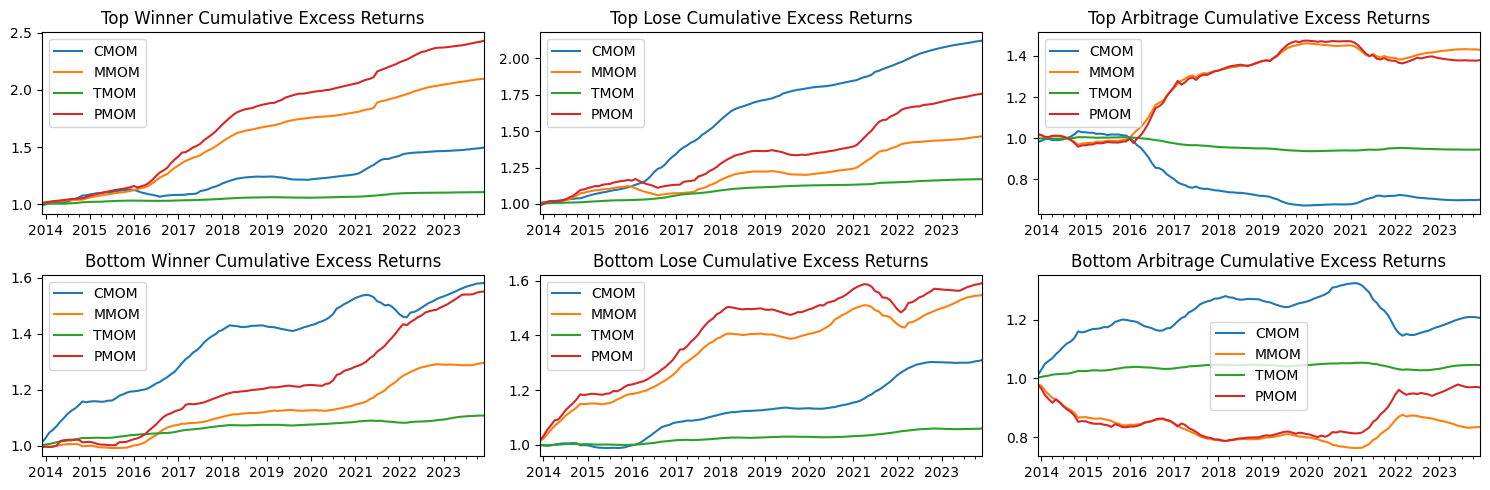

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 5))

(cum_top_ret_w.div(100).add(1).cumprod()).plot(ax=axes[0, 0], title='Top Winner Cumulative Excess Returns')
(cum_top_ret_l.div(100).add(1).cumprod()).plot(ax=axes[0, 1], title='Top Lose Cumulative Excess Returns')
(cum_top_ret_arb.div(100).add(1).cumprod()).plot(ax=axes[0, 2], title='Top Arbitrage Cumulative Excess Returns')

(cum_bottom_ret_w.div(100).add(1).cumprod()).plot(ax=axes[1, 0], title='Bottom Winner Cumulative Excess Returns')
(cum_bottom_ret_l.div(100).add(1).cumprod()).plot(ax=axes[1, 1], title='Bottom Lose Cumulative Excess Returns')
(cum_bottom_ret_arb.div(100).add(1).cumprod()).plot(ax=axes[1, 2], title='Bottom Arbitrage Cumulative Excess Returns')

plt.tight_layout()

plt.savefig("size_portfolio_cummulative_excess_ret.jpg", format='png', dpi=400)

plt.show()



In [19]:
mask_inf = long_monthly.unstack().r.where(long_daily.unstack().r == np.inf)

In [21]:
cum_top_ret_w.div(100).add(1).cumprod()

,CMOM,MMOM,TMOM,PMOM
2013-12-31,0.988001,1.006685,1.000306,1.009347
2014-01-31,0.997971,1.013858,1.001993,1.016329
2014-02-28,1.009954,1.017429,1.003904,1.021010
2014-03-31,1.014475,1.021154,1.004278,1.025579
2014-04-30,1.010566,1.023514,1.004401,1.028740
...,...,...,...,...
2023-08-31,1.480046,2.082349,1.103903,2.403972
2023-09-30,1.484329,2.086098,1.104177,2.409558
2023-10-31,1.487683,2.091581,1.104666,2.417374
2023-11-30,1.490707,2.094501,1.105066,2.421978
